In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.2.2


In [3]:
from torch_geometric.datasets import Reddit2
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import subgraph

dataset = Reddit2(root='data/Reddit', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Dataset: Reddit2():
Number of graphs: 1
Number of features: 602
Number of classes: 41

Data(x=[232965, 602], edge_index=[2, 23213838], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])
Number of nodes: 232965
Number of edges: 23213838
Average node degree: 99.65


## Manually wrangling data

In [4]:
torch.bincount(data.y)

tensor([13101,  3550,  3302, 15181,  2322,  3597,  3952,  2138, 11187,  2246,
         4928,  2964,  1696,  2731,  4854, 28272,  1003,  2639, 13999, 10308,
         1596,  4066,  8222, 12146,   328,  1659,  4239,  5962,  4673,  5101,
         2846,  4570,  1575,  4960,  3429,  4202,  4180,  4233, 12797,  3099,
         5112])

In [5]:
node_indices = torch.where(condition=((data.y == 4) |
                                      # (data.y == 5) |
                                      (data.y == 6)) == True)[0]
node_indices

tensor([    10,     12,     28,  ..., 232936, 232949, 232957])

In [6]:
edge_subset, edge_attr = subgraph(node_indices, data.edge_index, relabel_nodes=True)
print(edge_subset)
print(edge_subset.shape)

tensor([[   0,    0,    0,  ..., 6273, 6273, 6273],
        [ 118,  132,  276,  ..., 6056, 6215, 6253]])
torch.Size([2, 355634])


In [7]:
node_subset = data.x[node_indices]
data_x = node_subset
data_y = data.y[node_indices]
data_y[data_y == 4] = 0
data_y[data_y == 6] = 1
print(data_x.shape)
print(data_y.shape)

torch.Size([6274, 602])
torch.Size([6274])


In [8]:
data_y

tensor([1, 1, 0,  ..., 0, 1, 0])

In [9]:
alpha = 0.05

mask = torch.torch.rand((node_subset.shape[0]))
train_mask = mask > (1-alpha)
print(sum(train_mask))

test_mask = mask < alpha
print(sum(test_mask))

tensor(345)
tensor(325)


## MLP Model

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=602, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=41, bias=True)
)


In [11]:

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():

      model.train()
      optimizer.zero_grad()
      out = model(data_x)  # Single forward pass.
      loss = criterion(out[train_mask], data_y[train_mask])  # Compute loss
      loss.backward()  # Derive grads
      optimizer.step()  # Update params
      return loss

def test():
      model.eval()
      data_x = node_subset
      out = model(data_x)
      pred = out.argmax(dim=1)
      test_correct = pred[test_mask] == data_y[test_mask]
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Ratio of correct preds
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 3.5343
Epoch: 002, Loss: 3.4943
Epoch: 003, Loss: 3.4593
Epoch: 004, Loss: 3.4242
Epoch: 005, Loss: 3.3882
Epoch: 006, Loss: 3.3412
Epoch: 007, Loss: 3.2974
Epoch: 008, Loss: 3.2441
Epoch: 009, Loss: 3.1884
Epoch: 010, Loss: 3.1413
Epoch: 011, Loss: 3.0651
Epoch: 012, Loss: 2.9970
Epoch: 013, Loss: 2.9257
Epoch: 014, Loss: 2.8783
Epoch: 015, Loss: 2.7772
Epoch: 016, Loss: 2.7005
Epoch: 017, Loss: 2.6094
Epoch: 018, Loss: 2.5134
Epoch: 019, Loss: 2.4185
Epoch: 020, Loss: 2.3514
Epoch: 021, Loss: 2.2134
Epoch: 022, Loss: 2.1543
Epoch: 023, Loss: 2.0378
Epoch: 024, Loss: 1.9469
Epoch: 025, Loss: 1.8288
Epoch: 026, Loss: 1.7469
Epoch: 027, Loss: 1.6623
Epoch: 028, Loss: 1.5427
Epoch: 029, Loss: 1.4901
Epoch: 030, Loss: 1.4128
Epoch: 031, Loss: 1.3601
Epoch: 032, Loss: 1.2818
Epoch: 033, Loss: 1.2204
Epoch: 034, Loss: 1.1755
Epoch: 035, Loss: 1.1623
Epoch: 036, Loss: 1.0857
Epoch: 037, Loss: 1.0286
Epoch: 038, Loss: 1.0532
Epoch: 039, Loss: 1.0104
Epoch: 040, Loss: 0.9428


In [12]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6677


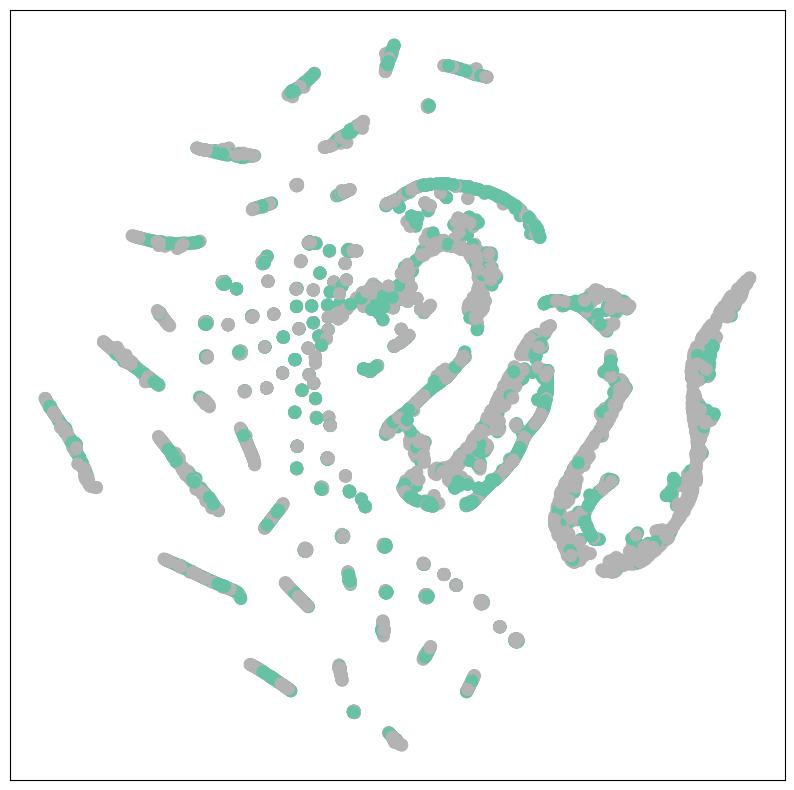

In [13]:
model.eval()
out = model(data_x)
visualize(out, color=data_y)

In [14]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.num_classes = torch.unique(data_y).shape[0]
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, self.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(602, 16)
  (conv2): GCNConv(16, 2)
)


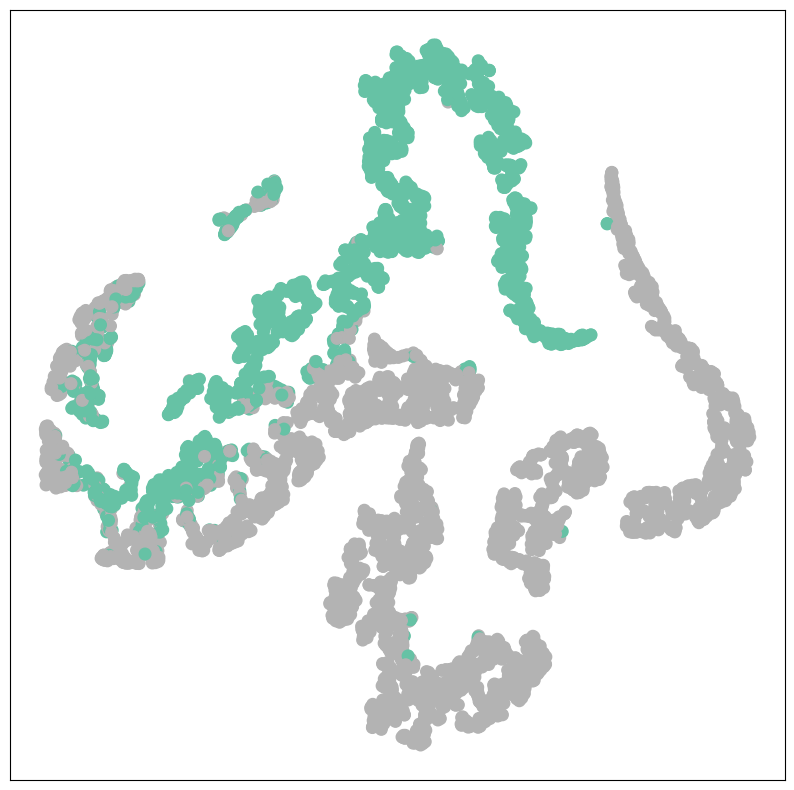

In [15]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data_x, edge_subset)
visualize(out, color=data_y)

In [16]:

model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data_x, edge_subset)  # Single forward pass.
      loss = criterion(out[train_mask], data_y[train_mask])  # Compute loss
      loss.backward()  # Derive grads
      optimizer.step()  # Update params
      return loss

def test():
      model.eval()
      out = model(data_x, edge_subset)
      pred = out.argmax(dim=1)
      test_correct = pred[test_mask] == data_y[test_mask]
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Ratio of correct preds
      return test_acc


for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.6947
Epoch: 002, Loss: 0.6816
Epoch: 003, Loss: 0.6728
Epoch: 004, Loss: 0.6645
Epoch: 005, Loss: 0.6573
Epoch: 006, Loss: 0.6534
Epoch: 007, Loss: 0.6505
Epoch: 008, Loss: 0.6492
Epoch: 009, Loss: 0.6434
Epoch: 010, Loss: 0.6434
Epoch: 011, Loss: 0.6393
Epoch: 012, Loss: 0.6350
Epoch: 013, Loss: 0.6323
Epoch: 014, Loss: 0.6294
Epoch: 015, Loss: 0.6212
Epoch: 016, Loss: 0.6195
Epoch: 017, Loss: 0.6142
Epoch: 018, Loss: 0.6079
Epoch: 019, Loss: 0.6071
Epoch: 020, Loss: 0.6019
Epoch: 021, Loss: 0.5944
Epoch: 022, Loss: 0.5899
Epoch: 023, Loss: 0.5849
Epoch: 024, Loss: 0.5773
Epoch: 025, Loss: 0.5720
Epoch: 026, Loss: 0.5667
Epoch: 027, Loss: 0.5609
Epoch: 028, Loss: 0.5548
Epoch: 029, Loss: 0.5453
Epoch: 030, Loss: 0.5393
Epoch: 031, Loss: 0.5313
Epoch: 032, Loss: 0.5190
Epoch: 033, Loss: 0.5157
Epoch: 034, Loss: 0.5060
Epoch: 035, Loss: 0.4971
Epoch: 036, Loss: 0.4927
Epoch: 037, Loss: 0.4856
Epoch: 038, Loss: 0.4792
Epoch: 039, Loss: 0.4657
Epoch: 040, Loss: 0.4582


In [17]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9477


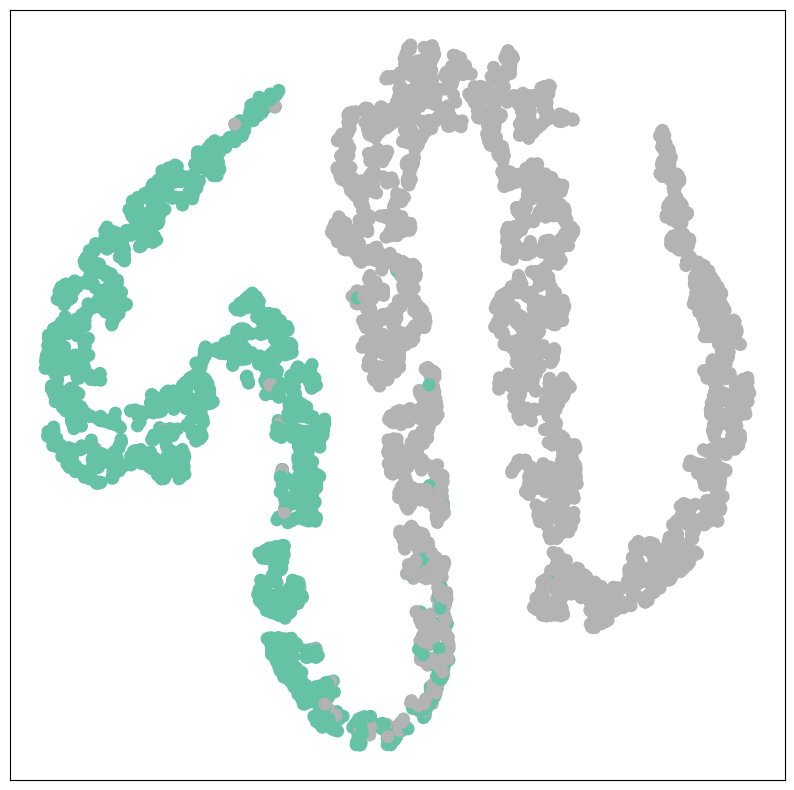

In [18]:
model.eval()

out = model(data_x, edge_subset)
visualize(out, color=data_y)